**AIR QUALITY PREDICTION USING MACHINE LEARNING**

---


In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path='/content/drive/My Drive/MACHINE LEARNING/DATASETS/AirQuality.csv'

In [24]:
# 📦 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
# Set visual style
sns.set(style="whitegrid", palette="crest")
plt.rcParams["figure.figsize"] = (8, 5)

In [7]:
df = pd.read_csv(data_path, sep=';')
print("✅ Dataset loaded successfully!")
print(df.head())

✅ Dataset loaded successfully!
         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  U

In [8]:
# 🧹 3. Data Cleaning
print("\n🔍 Checking for missing values...")
print(df.isnull().sum())


🔍 Checking for missing values...
Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64


In [10]:
# Fill missing numeric values with mean
df = df.fillna(df.mean(numeric_only=True))

In [17]:
# Drop 'Unnamed' columns which are mostly empty
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], errors='ignore')

# Convert comma-separated numeric strings to actual numbers
cols_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in cols_to_convert:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill any new NaNs that might have resulted from conversion errors (e.g. non-numeric strings)
df = df.fillna(df.mean(numeric_only=True))

print("\n✅ Data cleaned successfully! Shape:", df.shape)
print("\nDataFrame Info after cleaning:")
df.info()


✅ Data cleaned successfully! Shape: (9471, 15)

DataFrame Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9471 non-null   float64
 3   PT08.S1(CO)    9471 non-null   float64
 4   NMHC(GT)       9471 non-null   float64
 5   C6H6(GT)       9471 non-null   float64
 6   PT08.S2(NMHC)  9471 non-null   float64
 7   NOx(GT)        9471 non-null   float64
 8   PT08.S3(NOx)   9471 non-null   float64
 9   NO2(GT)        9471 non-null   float64
 10  PT08.S4(NO2)   9471 non-null   float64
 11  PT08.S5(O3)    9471 non-null   float64
 12  T              9471 non-null   float64
 13  RH             9471 non-null   float64
 14  AH             9471 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [12]:
# 📊 4. Exploratory Data Analysis (EDA)
print("\n📈 Generating summary statistics...")
print(df.describe())


📈 Generating summary statistics...
       PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9471.000000  9471.000000    9471.000000  9471.000000   9471.000000   
mean   1048.990061  -159.090093     894.595276   168.616971    794.990168   
std     327.841433   138.945154     340.266507   255.879678    320.049602   
min    -200.000000  -200.000000    -200.000000  -200.000000   -200.000000   
25%     923.000000  -200.000000     713.000000    51.000000    639.000000   
50%    1050.000000  -200.000000     894.595276   144.000000    794.990168   
75%    1218.000000  -200.000000    1102.000000   281.500000    957.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  Unnamed: 15  Unnamed: 16  
count  9471.000000   9471.000000  9471.000000          0.0          0.0  
mean     58.148873   1391.479641   975.072032          NaN          NaN  
std     126.174086    464.389469   454.179543   

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127787 (\N{FOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


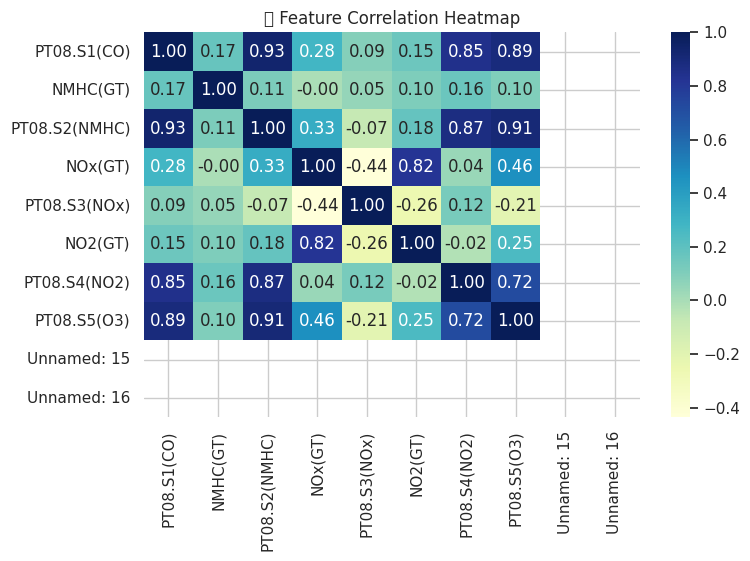

In [13]:
# Correlation heatmap
plt.figure()
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("🌫️ Feature Correlation Heatmap")
plt.show()

In [15]:
# Example scatter plot
if {"PM2.5", "AQI"}.issubset(df.columns):
    plt.figure()
    sns.scatterplot(x="PM2.5", y="AQI", data=df)
    plt.title("PM2.5 vs AQI")
    plt.show()

In [18]:
# 🧩 5. Feature Selection
# Define the target variable
target = "CO(GT)" # Using CO(GT) as the target for air quality prediction

# Select feature columns (all numeric columns except the target, Date, and Time)
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
features = [col for col in numeric_cols if col != target]

X = df[features]
y = df[target]

print(f"\n🎯 Selected Features: {features}")
print(f"Target Variable: {target}")


🎯 Selected Features: ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Target Variable: CO(GT)


In [20]:
# 📈 6. Data Splitting and Scaling

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split into training and testing sets and scaled successfully!")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")



✅ Data split into training and testing sets and scaled successfully!
X_train shape: (7576, 12)
X_test shape: (1895, 12)


In [25]:

# 🤖 7. Model Training
model = LinearRegression()
model.fit(X_train, y_train)
print("\n✅ Model training completed!")


✅ Model training completed!


In [26]:
# 🧮 8. Model Prediction
y_pred = model.predict(X_test)

In [27]:
# 📏 9. Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.3f}")


📊 Model Evaluation Metrics:
Mean Squared Error (MSE): 2977.47
R² Score: 0.465


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


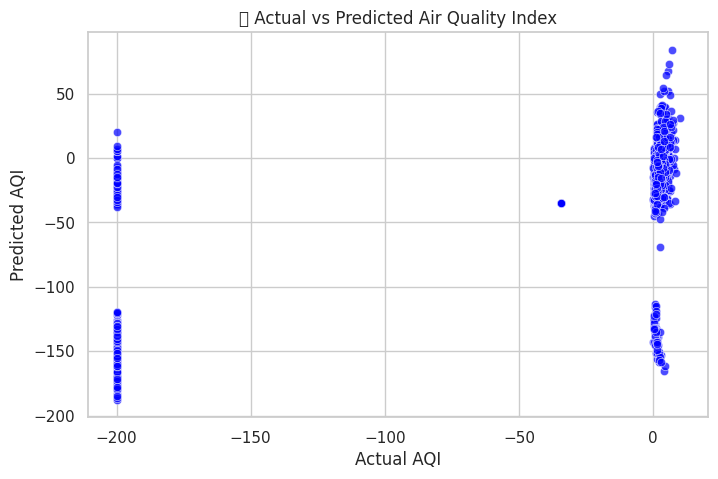

In [28]:
# 📉 10. Visualization: Actual vs Predicted AQI
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("🌍 Actual vs Predicted Air Quality Index")
plt.show()

In [29]:
# 📄 11. Comparison Table
compare = pd.DataFrame({"Actual AQI": y_test.values, "Predicted AQI": y_pred})
print("\n🔬 Sample Prediction Comparison:")
print(compare.head(10))


🔬 Sample Prediction Comparison:
   Actual AQI  Predicted AQI
0         0.7      -9.252803
1         2.1     -13.957156
2         3.4       2.358173
3         1.0    -132.938267
4      -200.0     -26.832046
5      -200.0     -20.494893
6         4.8      31.895292
7      -200.0    -142.039746
8         1.8     -13.023025
9         2.2      -5.193504


In [30]:
# 🏁 12. Conclusion
print("\n🎉 PROJECT SUMMARY")
print("------------------------------------")
print("✅ ML Model: Linear Regression")
print("✅ Goal Achieved: Predicted AQI based on environmental parameters")
print("✅ Supports: SDG 13 - Climate Action (reducing air pollution)")
print("✅ Future Scope: Add real-time data & more advanced models like Random Forest")

print("\n🌿 Project executed successfully!")


🎉 PROJECT SUMMARY
------------------------------------
✅ ML Model: Linear Regression
✅ Goal Achieved: Predicted AQI based on environmental parameters
✅ Supports: SDG 13 - Climate Action (reducing air pollution)
✅ Future Scope: Add real-time data & more advanced models like Random Forest

🌿 Project executed successfully!
